In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

c:\Users\User\anaconda3\envs\python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Generate dataset

In [50]:
# generate data ramdomly
# given v0, theta (features)
np.random.seed(0)
v0 = np.random.uniform(low=1, high=100, size=3000) # 1-100
theta = np.random.uniform(low=1, high=90, size=3000) # 1-90

def max_height(v0, theta):
    theta = theta*np.pi/180 # 換算為弧度
    h = (v0**2) * np.sin(theta)**2 / (2*9.8)
    return h

def max_length(v0, theta):
    theta = theta*np.pi/180
    l = (v0**2) * np.sin(2*theta) / 9.8
    return l

# calculate true max_height, max_length (targets)
max_h = max_height(v0, theta) # 斜拋最大高度
max_l = max_length(v0, theta) # 斜拋最大距離

print('The largest value of max_height: ', + np.max(max_h))
print('The largest value of max_length: ', + np.max(max_l))


The largest value of max_height:  504.98201571519775
The largest value of max_length:  1018.0119813371771


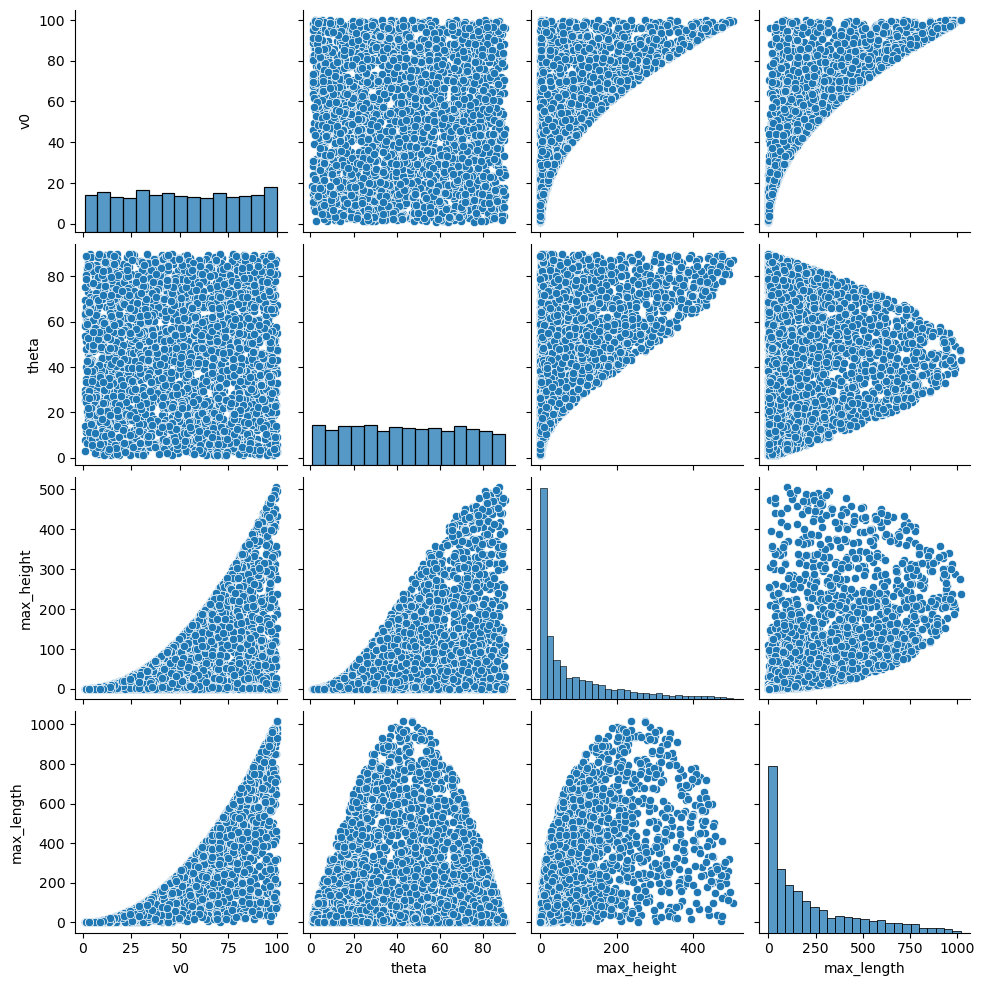

In [51]:
# pair plot
data = {'v0': v0, 'theta': theta, 'max_height': max_h, 'max_length': max_l}
data_f = pd.DataFrame(data)
sns.pairplot(data_f)

<AxesSubplot:>

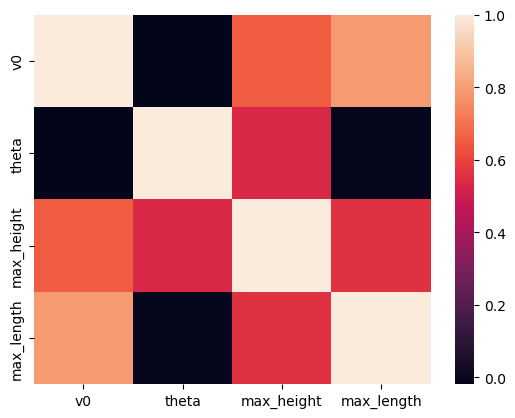

In [52]:
# correlation heatmap
sns.heatmap(data_f.corr())

In [53]:
# concate data
X = np.concatenate((v0.reshape(-1, 1), theta.reshape(-1, 1)), axis=1)
Y = np.concatenate((max_h.reshape(-1, 1), max_l.reshape(-1, 1)), axis=1)

# Functions and Classes

In [67]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_percentage_error
import time

# dataset
class Projectile_Dataset(Dataset):
    def __init__(self, x, y, train=True, pred_target='max_height'):
        if pred_target == 'max_height':
            y = y[:, 0]
        elif pred_target == 'max_length':
            y = y[:, 1]

        # train test split
        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=0)
        if train:
            x = x_train
            y = y_train
        else:
            x = x_test
            y = y_test
        
        # normalization
        scaler_x = MinMaxScaler()
        scaler_x.fit(x)
        x = scaler_x.transform(x)

        self.x = torch.from_numpy(x).type(torch.FloatTensor)
        self.y = torch.from_numpy(y).type(torch.FloatTensor) # n_samples, 1
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples


# models
class MaxH_DNN(nn.Module):
    def __init__(self):
        super(MaxH_DNN, self).__init__()
        # 大約3層
        self.layer1 = nn.Sequential(nn.Linear(2, 16), nn.LeakyReLU())
        self.layer2 = nn.Sequential(nn.Linear(16, 128), nn.LeakyReLU())
        self.layer3 = nn.Sequential(nn.Linear(128, 64), nn.LeakyReLU())
        self.layer4 = nn.Sequential(nn.Linear(64, 32), nn.LeakyReLU())
        self.layer5 = nn.Sequential(nn.Linear(32, 8), nn.LeakyReLU())
        self.layer6 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        return x

class MaxL_DNN(nn.Module):
    def __init__(self):
        super(MaxL_DNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(2, 16), nn.LeakyReLU())
        self.layer2 = nn.Sequential(nn.Linear(16, 128), nn.LeakyReLU())
        self.layer3 = nn.Sequential(nn.Linear(128, 256), nn.LeakyReLU())
        self.layer4 = nn.Sequential(nn.Linear(256, 128), nn.LeakyReLU())
        self.layer5 = nn.Sequential(nn.Linear(128, 64), nn.LeakyReLU())
        self.layer6 = nn.Sequential(nn.Linear(64, 16), nn.LeakyReLU())
        self.layer7 = nn.Linear(16, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        return x


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='Checkpoints/checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def train_model(model, train_loader, test_loader, num_epochs=500, lr=1e-2, weight_decay=1e-5, T_max=10, eta_min=1e-5, patience=20):
    """
    num_epochs : epochs 數量
    lr : 初始學習速率
    weight_decay : 權重衰退係數
    T_max : 調整學習速率的週期
    eta_min : 最小學習速率
    patience : 測試集誤差經過此數目epochs的學習後仍沒有改善誤差, 則停止訓練
    """
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min) # 隨著學習調整 lr
    criterion = nn.MSELoss() # loss function

    start = time.time()

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    n_total_steps = len(train_loader)

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    # 使用 gpu 運算
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda is available')
    model.to(device)

    for epoch in range(num_epochs):

        ##### Training loop #####
        model.train() # prep model for training
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.view(-1, 1).to(device)

            # forward
            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, targets))

            # backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            
        # update lr
        scheduler.step()

        ##### Validation loop #####
        model.eval() # prep model for evaluation
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.view(-1, 1).to(device)

            outputs = model(inputs)
            loss = torch.sqrt(criterion(outputs, targets))
            valid_losses.append(loss.item())
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        print(f'[Epoch {epoch+1}/{num_epochs}] train_loss: {train_loss:.2f}, valid_loss: {valid_loss:.2f}')

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('Checkpoints/checkpoint.pt'))
    
    end = time.time()
    print(f'Training is end. Total trainig time: {(end-start)/60:.1f} minutes')

    return model, avg_train_losses, avg_valid_losses


def loss_plot(avg_train_losses, avg_test_losses):
    plt.figure()
    plt.plot(avg_train_losses, 'r-', label='train')
    plt.plot(avg_test_losses, 'b-', label='valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('recorded loss')
    plt.legend()
    plt.show()


def model_evaluate(model, train_loader, test_loader, pred_target='max_height'):
    """
    Using RMSE & r2 score as metrics
    """
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda is available')

    model = model.to(device).eval() # evaluation mode
    train_rmse_lst = []
    test_rmse_lst = []
    train_mape_lst = []
    test_mape_lst = []

    if pred_target == 'max_height':
        xlim, ylim = 0, 600
    elif pred_target == 'max_length':
        xlim, ylim = 0, 1100

    fig, ax = plt.subplots(figsize=(6, 6))
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets
            outputs = model(inputs)

            mape_train = r2_score(outputs.view(-1), targets.view(-1).cuda())
            rmse_train = mean_squared_error(outputs.view(-1), targets.view(-1).cuda(), squared=False)
            
            train_rmse_lst.append(rmse_train.item())
            train_mape_lst.append(mape_train.item())

            # plot
            if i == 0:
                ax.plot(outputs.cpu(), targets, 'ro', markersize=5, label='train')
            else:
                ax.plot(outputs.cpu(), targets, 'ro', markersize=5)
        
        print(f'Training set|RMSE: {np.average(train_rmse_lst):.2f}, R2: {np.average(train_mape_lst)}')

        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets
            outputs = model(inputs)
            
            mape_test = r2_score(outputs.view(-1), targets.view(-1).cuda())
            rmse_test = mean_squared_error(outputs.view(-1), targets.view(-1).cuda(), squared=False)
            
            test_rmse_lst.append(rmse_test.item())
            test_mape_lst.append(mape_test.item())

            # plot
            if i == 0:
                ax.plot(outputs.cpu(), targets, 'bo', markersize=5, label='valid')
            else:
                ax.plot(outputs.cpu(), targets, 'bo', markersize=5)

        print(f'Testing set|RMSE: {np.average(test_rmse_lst):.2f}, R2: {np.average(test_mape_lst)}')

        ax.set_title(pred_target)
        ax.set_xlim(xlim, ylim)
        ax.set_ylim(xlim, ylim)
        ax.plot([xlim, ylim], [xlim, ylim], 'k--', linewidth=1.5)
        ax.set_xlabel('predicted')
        ax.set_ylabel('ground truth')
        ax.legend()
        plt.savefig('Figures/'+pred_target+'.png')
        plt.show()


# max_height train & evaluate

cuda is available
[Epoch 1/1000] train_loss: 102.70, valid_loss: 75.48
Validation loss decreased (inf --> 75.484505).  Saving model ...
[Epoch 2/1000] train_loss: 31.27, valid_loss: 15.11
Validation loss decreased (75.484505 --> 15.107895).  Saving model ...
[Epoch 3/1000] train_loss: 15.47, valid_loss: 25.12
EarlyStopping counter: 1 out of 100
[Epoch 4/1000] train_loss: 9.74, valid_loss: 5.31
Validation loss decreased (15.107895 --> 5.311961).  Saving model ...
[Epoch 5/1000] train_loss: 4.66, valid_loss: 4.99
Validation loss decreased (5.311961 --> 4.986567).  Saving model ...
[Epoch 6/1000] train_loss: 3.22, valid_loss: 3.58
Validation loss decreased (4.986567 --> 3.579220).  Saving model ...
[Epoch 7/1000] train_loss: 3.70, valid_loss: 2.16
Validation loss decreased (3.579220 --> 2.164764).  Saving model ...
[Epoch 8/1000] train_loss: 2.60, valid_loss: 2.54
EarlyStopping counter: 1 out of 100
[Epoch 9/1000] train_loss: 1.81, valid_loss: 1.78
Validation loss decreased (2.164764 --> 

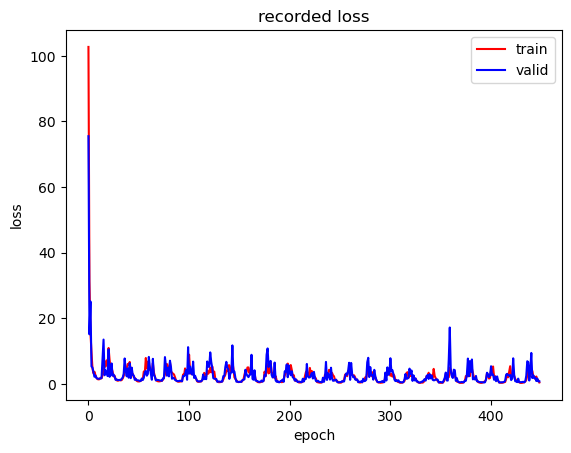

In [66]:
# initiate data loader
train_dataset = Projectile_Dataset(X, Y, train=True, pred_target='max_height')
test_dataset = Projectile_Dataset(X, Y, train=False, pred_target='max_height')
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True) # batch_size : 要分批餵入模型的資料大小
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=True)

# initiate model
maxh_model = MaxH_DNN()

# train
saved_model, train_loss, valid_loss = train_model(maxh_model, train_loader, test_loader, num_epochs=1000, lr=1e-2, weight_decay=1e-6, T_max=10, eta_min=1e-6, patience=100)

# draw loss plot
loss_plot(train_loss, valid_loss)

cuda is available
Training set|RMSE: 0.44, R2: 0.9999834696451823
Testing set|RMSE: 0.41, R2: 0.9999866286913554


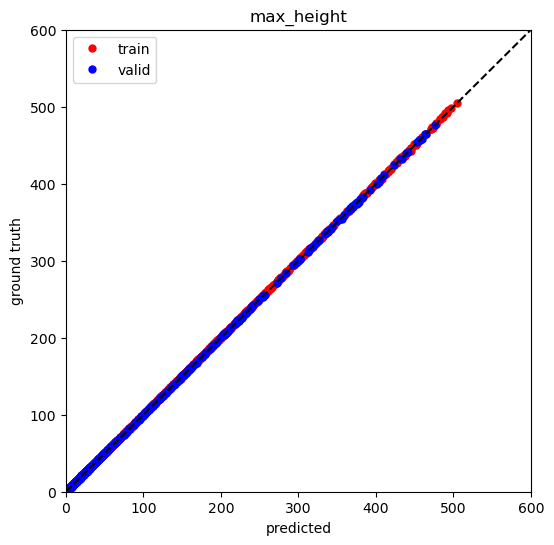

In [68]:
# initiate data loader
train_dataset = Projectile_Dataset(X, Y, train=True, pred_target='max_height')
test_dataset = Projectile_Dataset(X, Y, train=False, pred_target='max_height')
train_loader = DataLoader(train_dataset, batch_size=800, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

model_evaluate(maxh_model, train_loader, test_loader)

# max_length train & evaluate

cuda is available
[Epoch 1/1000] train_loss: 257.51, valid_loss: 202.41
Validation loss decreased (inf --> 202.406876).  Saving model ...
[Epoch 2/1000] train_loss: 136.42, valid_loss: 100.82
Validation loss decreased (202.406876 --> 100.820660).  Saving model ...
[Epoch 3/1000] train_loss: 65.69, valid_loss: 42.88
Validation loss decreased (100.820660 --> 42.880849).  Saving model ...
[Epoch 4/1000] train_loss: 35.83, valid_loss: 37.09
Validation loss decreased (42.880849 --> 37.086337).  Saving model ...
[Epoch 5/1000] train_loss: 33.95, valid_loss: 28.92
Validation loss decreased (37.086337 --> 28.922315).  Saving model ...
[Epoch 6/1000] train_loss: 26.64, valid_loss: 32.30
EarlyStopping counter: 1 out of 100
[Epoch 7/1000] train_loss: 21.45, valid_loss: 19.06
Validation loss decreased (28.922315 --> 19.060238).  Saving model ...
[Epoch 8/1000] train_loss: 17.49, valid_loss: 14.72
Validation loss decreased (19.060238 --> 14.722769).  Saving model ...
[Epoch 9/1000] train_loss: 15.3

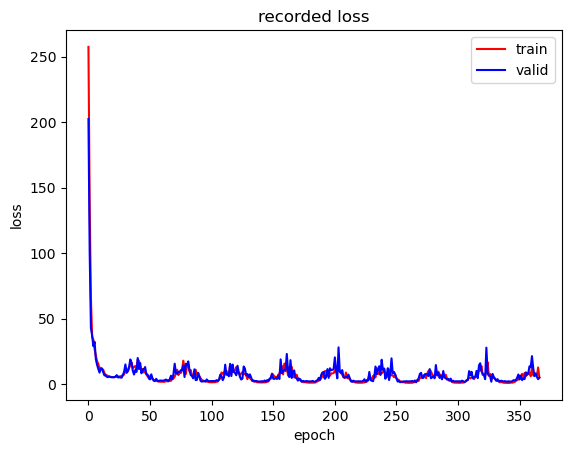

In [57]:
# initiate data loader
train_dataset_L = Projectile_Dataset(X, Y, train=True, pred_target='max_length')
test_dataset_L = Projectile_Dataset(X, Y, train=False, pred_target='max_length')
train_loader_L = DataLoader(train_dataset_L, batch_size=50, shuffle=True)
test_loader_L = DataLoader(test_dataset_L, batch_size=50, shuffle=False)

# initiate model
maxl_model = MaxL_DNN()

# train
saved_model_L, train_loss_L, valid_loss_L = train_model(maxl_model, train_loader_L, test_loader_L, num_epochs=1000, lr=5*1e-3, weight_decay=1e-6, T_max=20, eta_min=1e-6, patience=100)

# draw loss plot
loss_plot(train_loss_L, valid_loss_L)

cuda is available
Training set|RMSE: 1.61, R2: 0.9999567270278931
Testing set|RMSE: 1.38, R2: 0.9999680916468302


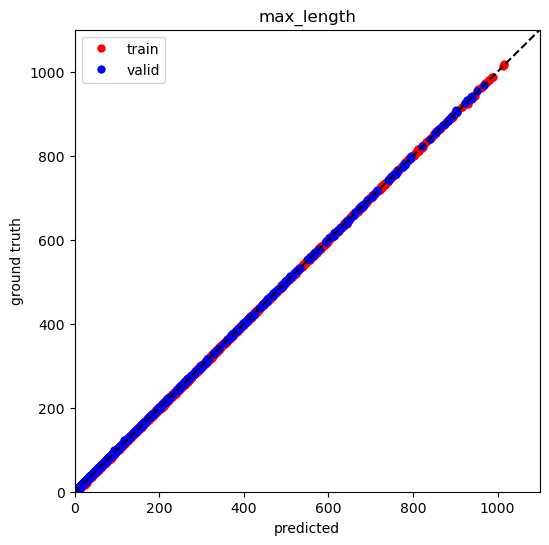

In [69]:
# initiate data loader
train_dataset_L = Projectile_Dataset(X, Y, train=True, pred_target='max_length')
test_dataset_L = Projectile_Dataset(X, Y, train=False, pred_target='max_length')
train_loader_L = DataLoader(train_dataset_L, batch_size=800, shuffle=False)
test_loader_L = DataLoader(test_dataset_L, batch_size=200, shuffle=False)

model_evaluate(maxl_model, train_loader_L, test_loader_L, pred_target='max_length')

# N-fold

In [ ]:
# 產生資料 模型(層數設計, activation function, loss function, metrics) 訓練結果(視覺化圖, n-fold)